# Radical Pilot Tutorial

Utilize the example below to familiarize yourself with Radical-Pilot.

* Adapt settings and username 
* Modify the example to print out the hostname of the machine that runs the Pilot


## 1. Installation and Configuration

Not required on <http://sc15-aws.radical-cybertools.org/>

If you want to install Radical-Pilot locally (Not needed on Cloud):

    pip install radical.pilot
    pip install radical.utils

In [2]:
%matplotlib inline
import os, sys
import commands
import radical.pilot as rp
import pandas as pd
import ast
import seaborn as sns
os.environ["RADICAL_PILOT_VERBOSE"]="ERROR"
!/opt/anaconda/bin/radicalpilot-version

v0.37.10-120-ga0fbbe3@tutorial-sc15


    
## 2. Radical Pilot Setup

Import dependency and create callbacks for state update

Documentation: http://radicalpilot.readthedocs.org/en/latest/machconf.html#preconfigured-resources

In [3]:
os.environ["RADICAL_PILOT_DBURL"]="mongodb://ec2-54-221-194-147.compute-1.amazonaws.com:24242/sc15-test000"
os.environ["RADICAL_PILOT_VERBOSE"]="DEBUG"

def print_details(detail_object):
    if type(detail_object)==str:
        detail_object = ast.literal_eval(detail_object)
    for i in detail_object:
        detail_object[i]=str(detail_object[i])
    return pd.DataFrame(detail_object.values(), 
             index=detail_object.keys(), 
             columns=["Value"])

## 3. Local Pilot Example

### 3.1 Create a new Session and Pilot-Manager. 

In [4]:
session = rp.Session()
c = rp.Context('ssh')
c.user_id = "radical"
session.add_context(c)
pmgr = rp.PilotManager(session=session)
umgr = rp.UnitManager (session=session,
                       scheduler=rp.SCHED_DIRECT_SUBMISSION)
print "Session id: %s Pilot Manager: %s" % (session.uid, str(pmgr.as_dict()))

Session id: rp.session.ip-10-99-194-113.ec2.internal.radical.016747.0025 Pilot Manager: {'uid': 'pmgr.0000'}


In [5]:
print_details(umgr.as_dict())

,Value
uid,umgr.0000
scheduler,DirectSubmissionScheduler
scheduler_details,NO SCHEDULER DETAILS (Not Implemented)


### 3.2 Submit Pilot and add to Unit Manager

In [6]:
pdesc = rp.ComputePilotDescription ()
pdesc.resource = "local.localhost_anaconda"  # NOTE: This is a "label", not a hostname
pdesc.runtime  = 10 # minutes
pdesc.cores    = 16
pdesc.cleanup  = False
pilot = pmgr.submit_pilots(pdesc)
umgr.add_pilots(pilot)

In [7]:
print_details(pilot.as_dict())

,Value
uid,pilot.0000
stdout,None
start_time,None
resource_detail,"{'cores_per_node': None, 'nodes': None}"
submission_time,1447010305.22
logfile,None
resource,local.localhost_anaconda
log,[]
sandbox,file://localhost/home/radical/radical.pilot.sa...
state,PendingLaunch


### 3.3 Submit Compute Units

Create a description of the compute unit, which specifies the details on the executed task.

In [8]:
cudesc = rp.ComputeUnitDescription()
cudesc.environment = {'CU_NO': 1}
cudesc.executable  = "/bin/echo"
cudesc.arguments   = ['I am CU number $CU_NO']
cudesc.cores       = 1
print_details(cudesc.as_dict())

,Value
kernel,None
executable,/bin/echo
name,None
restartable,False
output_staging,None
stdout,None
pre_exec,None
mpi,False
environment,{'CU_NO': 1}
cleanup,False


Submit the previously created ComputeUnit descriptions to the PilotManager. This will trigger the selected scheduler to start assigning ComputeUnits to the ComputePilots.

In [9]:
print "Submit Compute Units to Unit Manager ..."
cu_set = umgr.submit_units([cudesc])
print "Waiting for CUs to complete ..."
umgr.wait_units()
print "All CUs completed successfully!"
cu_results = cu_set[0]
details=cu_results.as_dict()

Submit Compute Units to Unit Manager ...
Waiting for CUs to complete ...
All CUs completed successfully!


In [10]:
print_details(details)

,Value
log,[<radical.pilot.logentry.Logentry object at 0x...
state,Done
working_directory,file://localhost/home/radical/radical.pilot.sa...
uid,unit.000000
submission_time,1447010307.72
execution_details,"{u'control': u'umgr', u'stdout': u'I am CU num..."
stop_time,None
start_time,None
exit_code,0
name,None


In [11]:
print_details(details["execution_details"])

,Value
control,umgr
stdout,I am CU number 1\n
callbackhistory,"[{u'timestamp': 1447010308.622181, u'state': u..."
Agent_Output_Directives,[]
Agent_Output_Status,None
Agent_Input_Status,None
exec_locs,None
FTW_Input_Directives,[]
log,"[{u'timestamp': 1447010307.731926, u'message':..."
exit_code,0


Process Output of CU

In [12]:
print cu_results.stdout.strip()

I am CU number 1


### 3.4 Exercise

Write a Compute Unit that prints out the hostname of the machine!

### 3.5 Performance Analysis

In [13]:
def get_runtime(compute_unit):
    details=compute_unit.as_dict()
    execution_details=details['execution_details']
    state_details=execution_details["statehistory"]
    results = {}
    for i in state_details:
        results[i["state"]]=i["timestamp"]
    start = results["Scheduling"]
    end = results["Done"]
    runtime = end-start
    return runtime


In [21]:
import random
cudesc_list = []
for i in range(100):
    cudesc = rp.ComputeUnitDescription()
    cudesc.executable  = "/bin/sleep"
    cudesc.environment = {'CU_NO': i}
    cudesc.arguments   = ['%d'%(random.randrange(10))]
    cudesc.cores       = 1
    cudesc_list.append(cudesc)

In [22]:
cu_set = umgr.submit_units(cudesc_list)

In [29]:
states = umgr.wait_units()

In [30]:
runtimes=[]
for compute_unit in cu_set:
    str(compute_unit)
    runtimes.append(get_runtime(compute_unit))

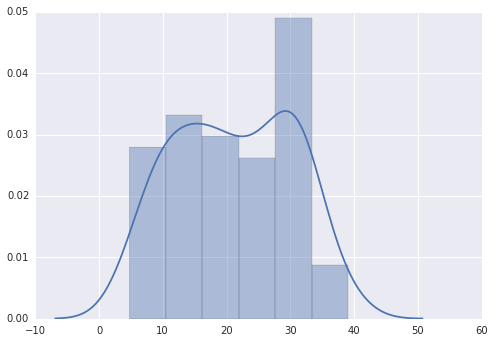

In [31]:
sns.distplot(runtimes)

### 3.6 Close Session

In [28]:
session.close()

# 4. YARN Pilot Example

In [29]:
yarn_session = rp.Session()
c = rp.Context('ssh')
c.user_id = "radical"
session.add_context(c)
pmgr = rp.PilotManager(session=yarn_session)
umgr = rp.UnitManager (session=yarn_session,
                       scheduler=rp.SCHED_DIRECT_SUBMISSION)
print "Session id: %s Pilot Manager: %s" % (yarn_session.uid, str(pmgr.as_dict()))

Session id: rp.session.ip-10-99-194-113.ec2.internal.radical.016747.0016 Pilot Manager: {'uid': 'pmgr.0003'}


In [30]:
pdesc = rp.ComputePilotDescription ()
pdesc.resource = "yarn.chameleon_anaconda"  # NOTE: This is a "label", not a hostname
pdesc.runtime  = 30 # minutes
pdesc.cores    = 16
pdesc.cleanup  = False
# submit the pilot.
print "Submitting Compute Pilot to Pilot Manager ..."
pilot = pmgr.submit_pilots(pdesc)
umgr.add_pilots(pilot)

Submitting Compute Pilot to Pilot Manager ...


NoSuccess: Could not detect shell prompt (timeout) (/opt/anaconda/lib/python2.7/site-packages/saga/utils/pty_shell_factory.py +285 (_initialize_pty)  :  raise se.NoSuccess ("Could not detect shell prompt (timeout)"))

In [ ]:
cudesc = rp.ComputeUnitDescription()
cudesc.environment = {'CU_NO': i}
cudesc.executable  = "/bin/echo"
cudesc.arguments   = ['I am CU number $CU_NO']
cudesc.cores       = 1